In [3]:
import graph_tool.all as gt
import random
import numpy as np

In [4]:
g = gt.Graph(directed=False)
name = g.vp["name"] = g.new_vp("string")
kind = g.vp["kind"] = g.new_vp("int")
weight = g.ep["count"] = g.new_ep("float")


D = 100
W = 20
W1 = 10

for i in range(D):
    n = g.add_vertex()
    name[n]=i
    kind[n]=0
        
for i in range(W):
    n = g.add_vertex()
    name[n]=i+D
    kind[n]=1
    
for i in range(W1):
    n = g.add_vertex()
    name[n]=i+D+W
    kind[n]=2
    
for i in range(D):
    for j in range(W):
        e = g.add_edge(i,j+D, False)
        weight[e] = int(random.randint(1,5))
    for j in range(W1):
        e = g.add_edge(i,j+D+W, False)
        weight[e] = int(random.randint(1,5))

In [5]:
for _ in range(1000):
    i = random.randint(0, D-1)
    j = random.randint(D, D+W-1)
    e = g.add_edge(i, j, False)
    weight[e] = random.randint(1,100)

In [44]:
%load_ext autoreload
%autoreload 2
from trisbm import trisbm

In [72]:
model = trisbm()
model.load_graph("graph.xml.gz")

In [73]:
g = model.g

In [74]:
len(list(g.vertices())),len(list(g.edges()))

(130, 4000)

In [75]:
clabel = g.vp['kind']
state_args = {'clabel': clabel, 'pclabel': clabel}
state_args["eweight"] = g.ep.count

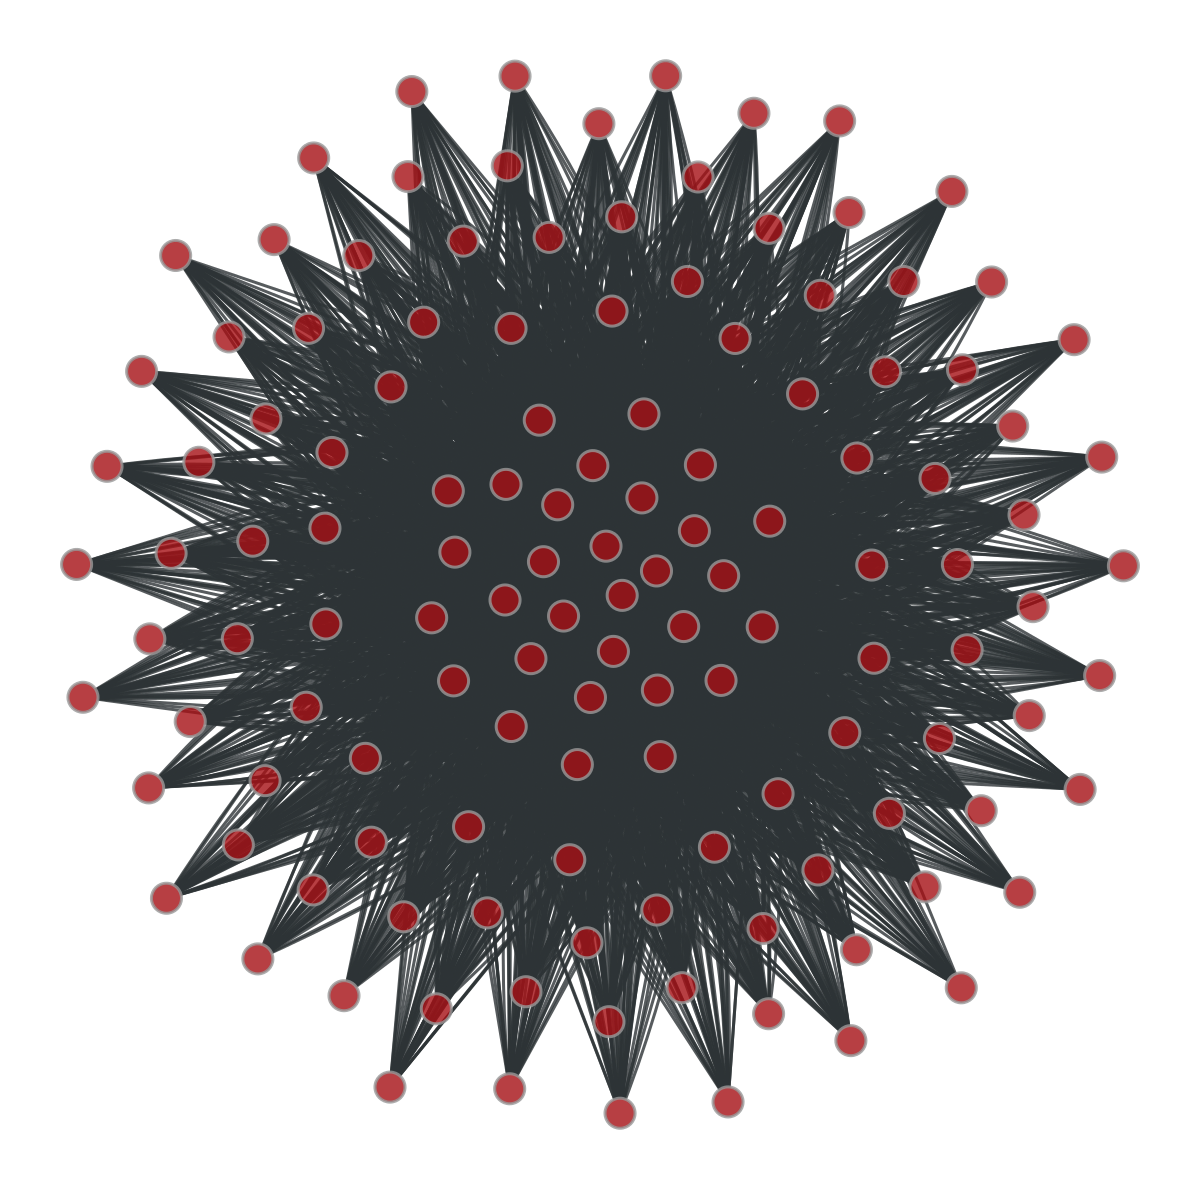

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f6cbc106a90, at 0x7f6caffb5bb0>

In [76]:
gt.graph_draw(g)

In [84]:
#model.fit()
state = model.state.copy(bs=state.get_bs() + [np.zeros(1)] * 4, sampling = True)

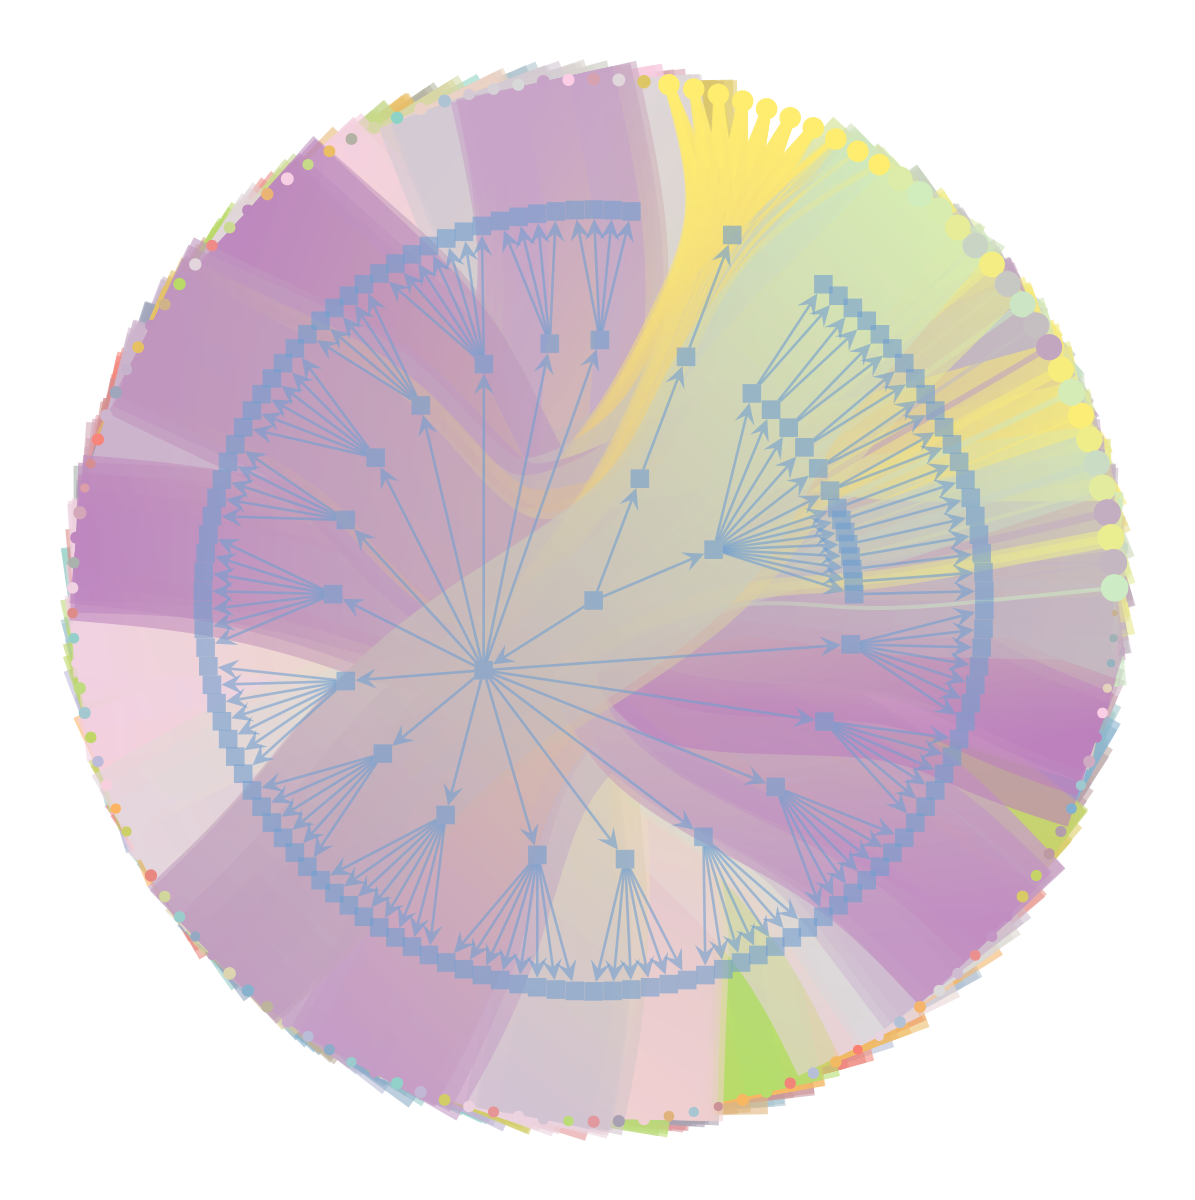

In [80]:
model.draw()

In [82]:
model.state.entropy()

10975.368544301333

In [85]:
for _ in range(100):
    state.multiflip_mcmc_sweep(beta=np.inf)

In [86]:
state.entropy()

10883.01418516554

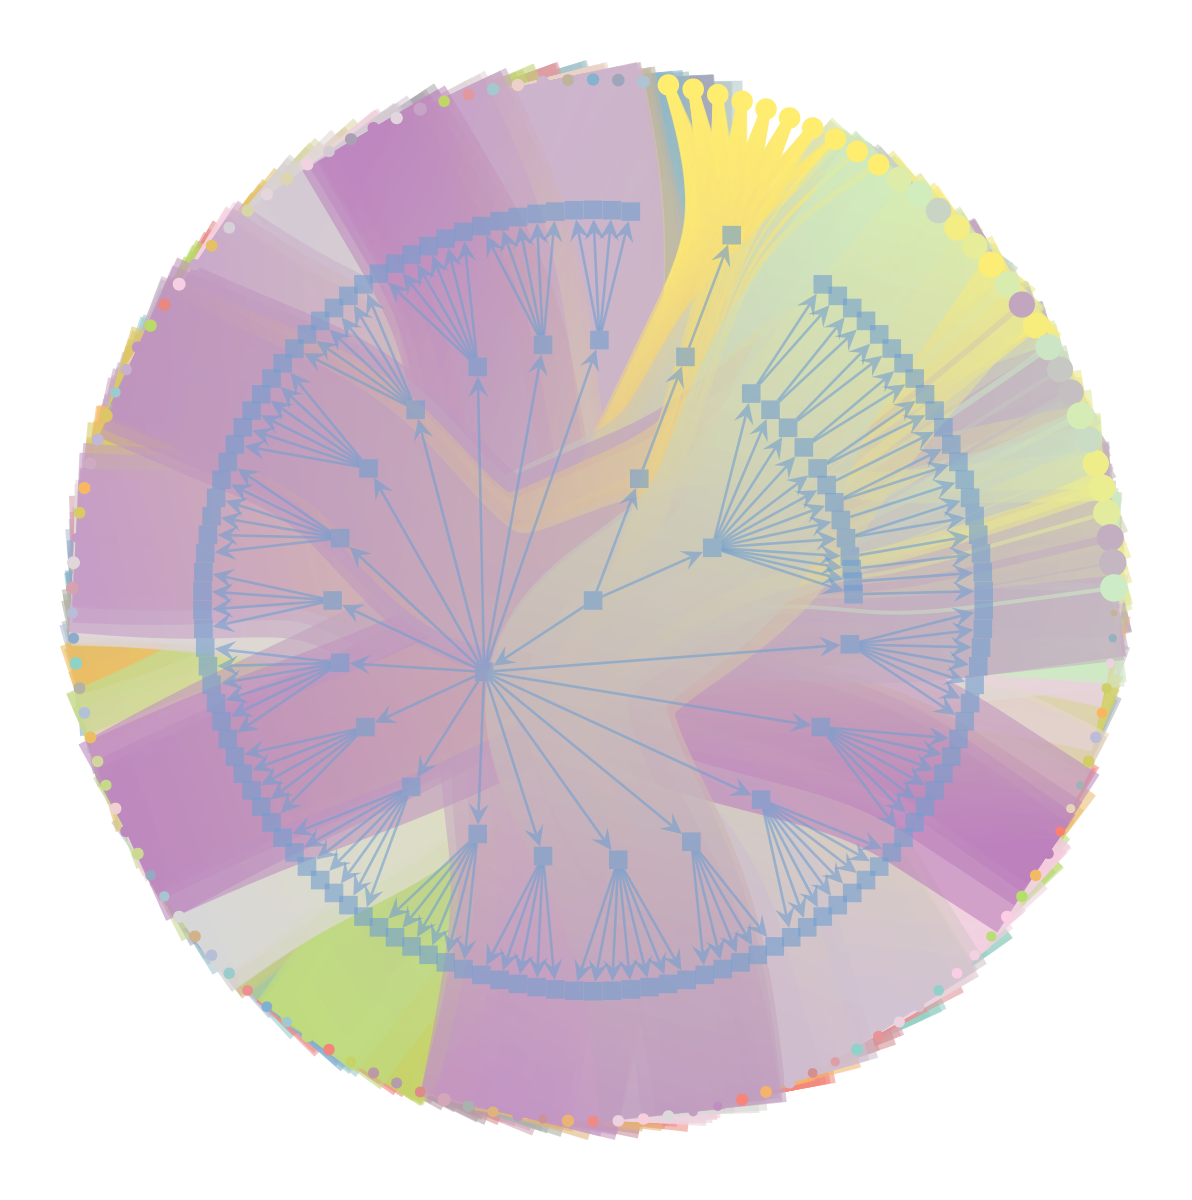

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f6d74b3dc70, at 0x7f6cbc0c97c0>,
 <Graph object, directed, with 286 vertices and 285 edges, at 0x7f6d8cacb1f0>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f6d8cacb1f0, at 0x7f6caff88a00>)

In [35]:
state.draw(subsample_edges=5000,
          edge_pen_width=g.ep["count"])

In [36]:
l=1
state_l = state.project_level(l).copy(overlap=True)
state_l_edges = state_l.get_edge_blocks()

In [37]:
B = state_l.B
D = int(np.sum(g.vp['kind'].a == 0)) #documents
W = int(np.sum(g.vp['kind'].a == 1)) #words
K = int(np.sum(g.vp['kind'].a == 2)) #keywords

n_dbw = np.zeros((D, B))
n_dbw_key = np.zeros((D, B))

for e in g.edges():
    z1, z2 = state_l_edges[e]
    v1 = e.source()
    v2 = e.target()
    if v2 < D + W:
        n_dbw[int(v1), z2] += 1
    else:
        n_dbw_key[int(v1), z2] += 1

In [38]:
#p_w = np.sum(n_wb, axis=1) / float(np.sum(n_wb))

#ind_d = np.where(np.sum(n_db, axis=0) > 0)[0]
#Bd = len(ind_d)
#n_db = n_db[:, ind_d]

#ind_w = np.where(np.sum(n_wb, axis=0) > 0)[0]
#Bw = len(ind_w)
#n_wb = n_wb[:, ind_w]

ind_w2 = np.where(np.sum(n_dbw, axis=0) > 0)[0]
n_dbw = n_dbw[:, ind_w2]

## Mixture of word-groups into documetns P(t_w | d)
p_tw_d = (n_dbw / np.sum(n_dbw, axis=1)[:, np.newaxis]).T

ind_w2_keyword = np.where(np.sum(n_dbw_key, axis=0) > 0)[0]
n_dbw_key = n_dbw_key[:, ind_w2_keyword]

## Mixture of word-groups into documetns P(t_w | d)
p_tw_d = (n_dbw / np.sum(n_dbw, axis=1)[:, np.newaxis]).T

## Mixture of word-groups into documetns P(t_w | d)
p_tk_d = (n_dbw_key / np.sum(n_dbw_key, axis=1)[:, np.newaxis]).T

result = {}
result['p_tw_d'] = p_tw_d
result['p_tk_d'] = p_tk_d

In [39]:
result['p_tw_d'].shape

(13, 100)

In [40]:
result['p_tk_d'].shape

(1, 100)